# Novel Fraud Analysis
We show that hybrid model with exploration detects novel frauds better (e.g., trades from new HS6 and new import ID)

In [1]:
import numpy as np
import pandas as pd
import glob 
import csv
import traceback
import datetime
import os
pd.options.display.max_columns=50

### Basic statistics and Novel fraud statistics

Number of test weeks:
* dfm: 196 weeks 
* dfn: 257 weeks 
* dft: 257 weeks 
* dfs: 48 weeks

In [2]:
def firstCheck(df):
    """ Sorting and indexing necessary for data preparation """
    df = df.dropna(subset=["illicit"])
    df = df.sort_values("sgd.date")
    df = df.reset_index(drop=True)
    return df

dfm = firstCheck(pd.read_csv('../data/mdata.csv'))
dfn = firstCheck(pd.read_csv('../data/ndata.csv'))
dft = firstCheck(pd.read_csv('../data/tdata.csv'))
dfc = firstCheck(pd.read_csv('../data/cdata.csv'))
dfs = firstCheck(pd.read_csv('../data/synthetic-imports-declarations.csv'))

In [4]:
for df in [dfm, dfn, dft, dfc, dfs]:
    print(df['importer.id'].nunique(), df['tariff.code'].nunique(), df['country'].nunique())

40543 1916 149
165202 5953 229
132893 13387 195
8699 5491 241
8653 1894 112


In [8]:
dfs

,sgd.id,sgd.date,importer.id,declarant.id,country,office.id,tariff.code,quantity,gross.weight,fob.value,cif.value,total.taxes,illicit,revenue
0,SGD1,13-01-02,IMP826164,DEC3207,CNTRY680,OFFICE92,8703241128,1581,26494,2390,2809,647,0,0
1,SGD196,13-01-02,IMP271968,DEC5544,CNTRY680,OFFICE92,8703900000,1,328548,8852,8852,3140,0,0
2,SGD195,13-01-02,IMP717735,DEC2596,CNTRY759,OFFICE51,3004900000,21,34542,6746,8891,3662,0,0
3,SGD194,13-01-02,IMP116006,DEC1243,CNTRY680,OFFICE51,8703321922,1,25243,28554,34757,3585,0,0
4,SGD193,13-01-02,IMP712264,DEC9013,CNTRY376,OFFICE51,8703231119,259,204486,3586,4440,2442,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,SGD99816,13-12-31,IMP442440,DEC7804,CNTRY378,OFFICE51,5801900000,4,124936,154031,202095,9297,1,602
99996,SGD99815,13-12-31,IMP306228,DEC7336,CNTRY264,OFFICE60,3206190000,1,87904,621548,857565,1164,1,869
99997,SGD99814,13-12-31,IMP245658,DEC8312,CNTRY976,OFFICE66,8704221100,61,39895,955688,1096716,352,0,0
99998,SGD99820,13-12-31,IMP302697,DEC6832,CNTRY376,OFFICE59,8703232926,1,28235,144152,208523,11881,0,0


In [15]:
dfs[dfs['importer.id'] == 'IMP826164']['tariff.code'].value_counts()

8703241128    174
8703232926    138
8703222900     79
8703900000     78
8703321922     77
             ... 
8413300000      1
5007900000      1
7005210000      1
2915700000      1
3215190019      1
Name: tariff.code, Length: 99, dtype: int64

In [7]:
dfs['importer.id'].value_counts()

IMP826164    1077
IMP173637     884
IMP450852     859
IMP243951     782
IMP238427     714
             ... 
IMP342718       1
IMP133718       1
IMP644361       1
IMP759793       1
IMP371480       1
Name: importer.id, Length: 8653, dtype: int64

In [9]:
dfs['country'].value_counts()

CNTRY680    29518
CNTRY759    19170
CNTRY376    10877
CNTRY615     4055
CNTRY454     3260
            ...  
CNTRY415      109
CNTRY252      107
CNTRY379      106
CNTRY343      101
CNTRY278       99
Name: country, Length: 112, dtype: int64

In [13]:
dfs['tariff.code'].apply(lambda x: x//100000000).value_counts()

87    67556
85     6922
84     4814
39     1773
73     1757
      ...  
97        8
46        5
5         4
93        4
1         2
Name: tariff.code, Length: 91, dtype: int64

In [17]:
dfs['HS2'] = dfs['tariff.code'].apply(lambda x: x//100000000)

In [20]:
dfs.groupby(['HS2'])['illicit'].apply(np.mean)

HS2
1     0.000000
2     0.320000
3     0.123418
4     0.187192
5     0.500000
        ...   
93    0.500000
94    0.213115
95    0.256098
96    0.251748
97    0.500000
Name: illicit, Length: 91, dtype: float64

#### Average illicit rates

In [102]:
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


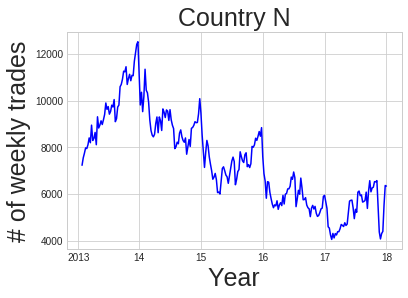

In [115]:
plt.style.use('seaborn-whitegrid')
f = plt.figure()
plt.plot(pd.Series(num_trades_n).rolling(4).mean(), color='blue')
plt.title('Country N', fontsize=25)
plt.xlabel('Year', fontsize=25)
plt.ylabel('# of weekly trades', fontsize=25)
plt.xticks(ticks=[0,51,103,155,207,259], labels=['2013', 14, 15, 16, 17, 18])
f.savefig("num_weekly_trades_n.pdf", bbox_inches='tight')

In [116]:

date_begin = '20130101'
test_length = 7

start_day = datetime.date(int(date_begin[:4]), int(date_begin[4:6]), int(date_begin[6:8]))
period = datetime.timedelta(days=test_length)    
end_day = start_day + datetime.timedelta(days=test_length)    

old_IID = set()
new_proportions = []

novel_rate_n = []

for week in range(260):
    weekly_trade = dfn[(dfn['sgd.date'] < end_day.strftime('%y-%m-%d')) & (dfn['sgd.date'] >= start_day.strftime('%y-%m-%d'))]
    start_day = end_day
    end_day = start_day + datetime.timedelta(days=test_length)
    new_trade = weekly_trade[~weekly_trade['importer.id'].isin(old_IID)]
    old_IID = old_IID.union(weekly_trade['importer.id'].values)
    novel_rate_n.append(sum(new_trade['illicit'])/len(weekly_trade))
print(novel_rate_n)

[0.027422585117855492, 0.01763055963670362, 0.012178104782443232, 0.015282298004811094, 0.01650548033526757, 0.014844315713251267, 0.01601181012945719, 0.017998560115190784, 0.011511986707809162, 0.008796100042390844, 0.01277555110220441, 0.011054165410511506, 0.007746600103288002, 0.014717906786590351, 0.012766429840142096, 0.011466428844438782, 0.00831129580657348, 0.007247298156389066, 0.0053678560151563, 0.008387698042870456, 0.0064282844515869825, 0.005077313639510732, 0.005275779376498801, 0.004079696394686907, 0.007220216606498195, 0.00514110697877926, 0.004928806133625411, 0.004269622093023256, 0.004026170105686965, 0.005433552184740774, 0.0047142582258995576, 0.006086595656384009, 0.005168453292496171, 0.006648199445983379, 0.00792910447761194, 0.006266872348630929, 0.005718502121379819, 0.0030714102892244687, 0.003968910203406648, 0.003315779208113907, 0.003924914675767918, 0.004373345609391184, 0.0034393151941302354, 0.003182396799418076, 0.004987296508892443, 0.003539454507

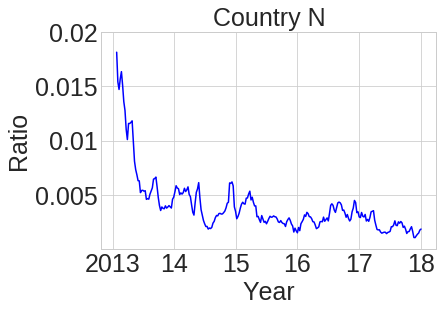

In [154]:
plt.style.use('seaborn-whitegrid')
f = plt.figure()
plt.plot(pd.Series(novel_rate_n).rolling(4).mean(), color='blue')
plt.title('Country N', fontsize=25)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Ratio', fontsize=25)
plt.xticks(ticks=[0,51,103,155,207,259], labels=['2013', 14, 15, 16,17,18], fontsize=25)
plt.yticks(ticks=[0.005, 0.01, 0.015, 0.02], labels=[0.005, 0.01, 0.015, 0.02], fontsize=25)
plt.ylim(0, 0.02)
f.savefig("proportion-of-novel-frauds-from-new-importer-n.pdf", bbox_inches='tight')

In [118]:
# Tunisia

date_begin = '20150101'
test_length = 7

start_day = datetime.date(int(date_begin[:4]), int(date_begin[4:6]), int(date_begin[6:8]))
period = datetime.timedelta(days=test_length)    
end_day = start_day + datetime.timedelta(days=test_length)    

old_IID = set()
new_proportions = []

avg_illicit_rates_t = []
num_trades_t = []
for week in range(260):
    weekly_trade = dft[(dft['sgd.date'] < end_day.strftime('%y-%m-%d')) & (dft['sgd.date'] >= start_day.strftime('%y-%m-%d'))]
    start_day = end_day
    end_day = start_day + datetime.timedelta(days=test_length)
    avg_illicit_rates_t.append(np.mean(weekly_trade['illicit']))
    num_trades_t.append(len(weekly_trade))

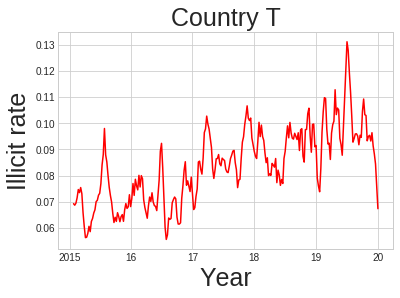

In [119]:
plt.style.use('seaborn-whitegrid')
f = plt.figure()
plt.plot(pd.Series(avg_illicit_rates_t).rolling(4).mean(), color='red')
plt.title('Country T', fontsize=25)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Illicit rate', fontsize=25)
plt.xticks(ticks=[0,51,103,155,207,259], labels=['2015', 16, 17, 18, 19, 20])
f.savefig("illicit_rate_t.pdf", bbox_inches='tight')

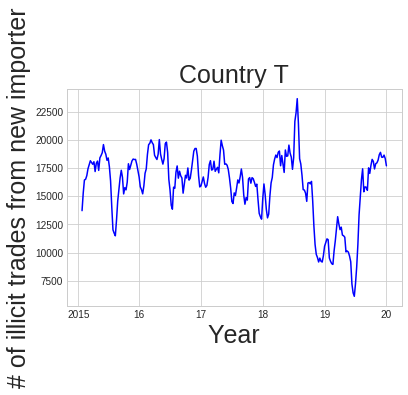

In [126]:
plt.style.use('seaborn-whitegrid')
f = plt.figure()
plt.plot(pd.Series(num_trades_t).rolling(4).mean(), color='blue')
plt.title('Country T', fontsize=25)
plt.xlabel('Year', fontsize=25)
plt.ylabel('# of illicit trades from new importer', fontsize=25)
plt.xticks(ticks=[0,51,103,155,207,259], labels=['2015', 16, 17, 18,19, 20])
f.savefig("num_weekly_trades_t.pdf", bbox_inches='tight')

In [157]:
date_begin = '20150101'
test_length = 7

start_day = datetime.date(int(date_begin[:4]), int(date_begin[4:6]), int(date_begin[6:8]))
period = datetime.timedelta(days=test_length)    
end_day = start_day + datetime.timedelta(days=test_length)    

old_IID = set()
new_proportions = []   

old_IID = set()
new_proportions = []

novel_rate_t = []

for week in range(260):
    weekly_trade = dft[(dft['sgd.date'] < end_day.strftime('%y-%m-%d')) & (dft['sgd.date'] >= start_day.strftime('%y-%m-%d'))]
    start_day = end_day
    end_day = start_day + datetime.timedelta(days=test_length)
    new_trade = weekly_trade[~weekly_trade['importer.id'].isin(old_IID)]
    old_IID = old_IID.union(weekly_trade['importer.id'].values)
    novel_rate_t.append(sum(new_trade['illicit'])/len(weekly_trade))
print(novel_rate_t)

[0.07941419141914191, 0.048955173576002695, 0.03499577345731192, 0.029967343279759237, 0.028001750109381836, 0.02526507119054832, 0.013126425273930696, 0.025, 0.01805660991215703, 0.018124024091010483, 0.019979402677651904, 0.008984615384615384, 0.008293639674978986, 0.009978238946977337, 0.015756434400502197, 0.009324373600041673, 0.010630872483221476, 0.0125, 0.01696743821106316, 0.0072373346643374095, 0.01009020027518728, 0.011020031485804245, 0.01522702104097453, 0.008239146508925743, 0.008481375358166189, 0.01064769126889316, 0.011405568601140557, 0.015335877312981496, 0.005705960908097609, 0.006136076520483667, 0.0044522297642507844, 0.006718665534018071, 0.0044668587896253605, 0.005780671231339096, 0.00451773209848656, 0.006312098188194039, 0.005513604219105837, 0.0036639623135304895, 0.006094464195022855, 0.003979945211143847, 0.001887267237040765, 0.003883495145631068, 0.003754897692642577, 0.005202612867795826, 0.006585351886846475, 0.0023572819514194937, 0.002993540255238695

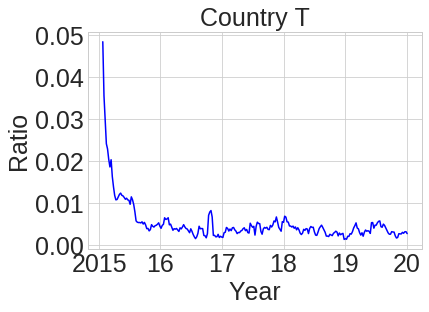

In [158]:
plt.style.use('seaborn-whitegrid')
f = plt.figure()
plt.plot(pd.Series(novel_rate_t).rolling(4).mean(), color='blue')
plt.title('Country T', fontsize=25)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Ratio', fontsize=25)
plt.xticks(ticks=[0,51,103,155,207, 259], labels=['2015', 16, 17, 18,19,20], fontsize=25)
# plt.yticks(ticks=[0.005, 0.01, 0.015, 0.02], labels=[0.005, 0.01, 0.015, 0.02], fontsize=25)
# plt.ylim(0, 0.02)
plt.yticks(fontsize=25)
f.savefig("proportion-of-novel-frauds-from-new-importer-t.pdf", bbox_inches='tight')

In [12]:
# Synthetic

date_begin = '20130101'
test_length = 7

start_day = datetime.date(int(date_begin[:4]), int(date_begin[4:6]), int(date_begin[6:8]))
period = datetime.timedelta(days=test_length)    
end_day = start_day + datetime.timedelta(days=test_length)    

old_IID = set()
new_proportions = []

avg_illicit_rates_s = []
num_trades_s = []

for week in range(52):
    weekly_trade = dfs[(dfs['sgd.date'] < end_day.strftime('%y-%m-%d')) & (dfm['sgd.date'] >= start_day.strftime('%y-%m-%d'))]
    start_day = end_day
    end_day = start_day + datetime.timedelta(days=test_length)
    avg_illicit_rates_s.append(np.mean(weekly_trade['illicit']))
    num_trades_s.append(len(weekly_trade))

/home/sundong/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [6]:
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [29]:
avg_illicit_rates_s = np.nan_to_num(np.array(avg_illicit_rates_s), nan=np.mean(dfs['illicit']))

In [11]:
avg_illicit_rates_s = avg_illicit_rates_s[:-13]

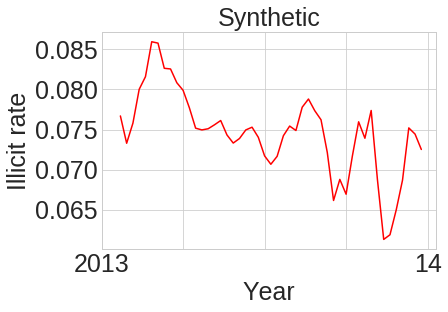

In [41]:
plt.style.use('seaborn-whitegrid')
f = plt.figure()
plt.plot(pd.Series(avg_illicit_rates_s).rolling(4).mean(), color='red')
plt.title('Synthetic', fontsize=25)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Illicit rate', fontsize=25)
plt.xticks(ticks=[0,13,26,39,52], labels=['2013','','','','14'], fontsize=25)
plt.yticks(fontsize=25)
f.savefig("illicit_rate_s.pdf", bbox_inches='tight')

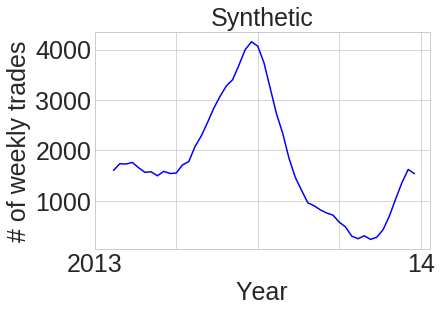

In [49]:
plt.style.use('seaborn-whitegrid')
f = plt.figure()
plt.plot(pd.Series(num_trades_s).rolling(4).mean(), color='blue')
plt.title('Synthetic', fontsize=25)
plt.xlabel('Year', fontsize=25)
plt.ylabel('# of weekly trades', fontsize=25)
plt.xticks(ticks=[0,13,26,39,52], labels=['2013', '','','',14], fontsize=25)
plt.yticks(ticks=[1000,2000,3000,4000], labels=[1000,2000,3000,4000], fontsize=25)
f.savefig("num_weekly_trades_s.pdf", bbox_inches='tight')

In [56]:
date_begin = '20130101'
test_length = 7

start_day = datetime.date(int(date_begin[:4]), int(date_begin[4:6]), int(date_begin[6:8]))
period = datetime.timedelta(days=test_length)    
end_day = start_day + datetime.timedelta(days=test_length)    

old_IID = set()
new_proportions = []

novel_rate_s = []

for week in range(52):
    weekly_trade = dfs[(dfs['sgd.date'] < end_day.strftime('%y-%m-%d')) & (dfm['sgd.date'] >= start_day.strftime('%y-%m-%d'))]
    start_day = end_day
    end_day = start_day + datetime.timedelta(days=test_length)
    new_trade = weekly_trade[~weekly_trade['importer.id'].isin(old_IID)]
    old_IID = old_IID.union(weekly_trade['importer.id'].values)
    try:
        novel_rate = sum(new_trade['illicit'])/len(weekly_trade)
    except:
        novel_rate = np.nan
    novel_rate_s.append(novel_rate)
print(novel_rate_s)
novel_rate_s = np.nan_to_num(np.array(novel_rate_s), nan=0)

/home/sundong/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


[0.0823262839879154, 0.050867743865948535, 0.04826732673267327, 0.037673130193905814, 0.0319091400757166, 0.04608853850818678, 0.056896551724137934, 0.028118240807498196, 0.03768506056527591, 0.03613744075829384, 0.03943661971830986, 0.03377218088151116, 0.028201219512195123, 0.027341477603257707, 0.022232962783953602, 0.020895522388059702, 0.022, 0.01671850699844479, 0.010522959183673469, 0.013040712468193385, 0.011915140947399011, 0.0088339222614841, 0.014340871483728626, 0.008387698042870456, 0.006850781417255406, 0.005213505461767627, 0.006398537477148081, 0.01011804384485666, 0.014399393709738537, 0.013426156141223273, 0.015133876600698487, 0.016145307769929364, 0.014991181657848324, 0.011224489795918367, 0.012295081967213115, 0.011842105263157895, 0.009913258983890954, 0.009549795361527967, 0.008802816901408451, 0.009950248756218905, 0.016317016317016316, nan, 0.00554016620498615, 0.013793103448275862, 0.0, 0.0, 0.008298755186721992, 0.015221707478491065, 0.008053691275167786, 0.

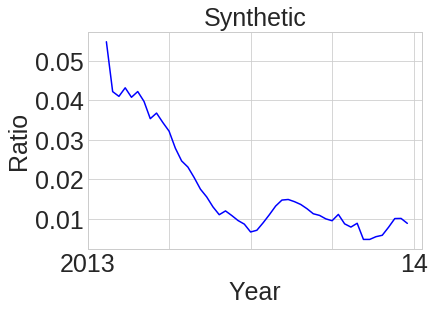

In [57]:
plt.style.use('seaborn-whitegrid')
f = plt.figure()
plt.plot(pd.Series(novel_rate_s).rolling(4).mean(), color='blue')
plt.title('Synthetic', fontsize=25)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Ratio', fontsize=25)
plt.xticks(ticks=[0,13,26,39,52], labels=['2013', '','','',14], fontsize=25)
plt.yticks(fontsize=25)
f.savefig("proportion-of-novel-frauds-from-new-importer-s.pdf", bbox_inches='tight')

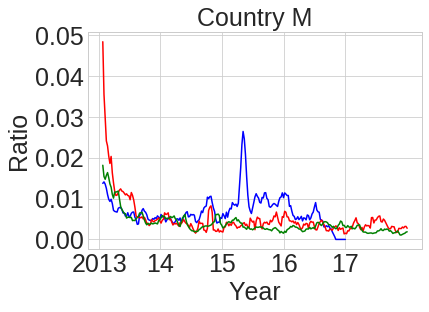

In [161]:
plt.style.use('seaborn-whitegrid')
f = plt.figure()
plt.plot(pd.Series(novel_rate_m).rolling(4).mean(), color='blue')
plt.plot(pd.Series(novel_rate_t).rolling(4).mean(), color='red')
plt.plot(pd.Series(novel_rate_n).rolling(4).mean(), color='green')
plt.title('Country M', fontsize=25)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Ratio', fontsize=25)
plt.xticks(ticks=[0,51,103,155,207], labels=['2013', 14, 15, 16,17], fontsize=25)
plt.yticks(fontsize=25)
f.savefig("proportion-of-novel-frauds-from-new-importer-mnt.pdf", bbox_inches='tight')

In [123]:
results = glob.glob('../results/performances/fld7-result-*')   # quick- or www21- or fld-
list1, list2 = zip(*sorted(zip([os.stat(result).st_size for result in results], results)))

In [245]:
# Retrieving results
num_logs = len([i for i in list1 if i > 1000])
count= 0
summary = []
for i in range(1,num_logs+1):
    rslt = pd.read_csv(list2[-i])
    dic = rslt[['runID','data','sampling','subsamplings','numWeek','current_inspection_rate','test_start','test_end']].iloc[len(rslt)-1].to_dict()
    run_id = round(dic['runID'], 3)
    data = dic['data']
    subsamplings = dic['subsamplings'].replace('/','+')
    strategy = dic['sampling']
    cir = dic['current_inspection_rate']
    summary.append(dic)
summary = pd.DataFrame(summary)

In [246]:
# Index will be used later
summary[summary.data == 'real-t']

,runID,data,sampling,subsamplings,numWeek,current_inspection_rate,test_start,test_end
0,1.603007e+09,real-t,random,-,257,10.0,19-12-29,20-01-05
1,1.603009e+09,real-t,random,-,257,10.0,19-12-29,20-01-05
15,1.603009e+09,real-t,enhanced_bATE,-,127,10.0,17-07-02,17-07-09
16,1.603009e+09,real-t,badge,-,124,10.0,17-06-11,17-06-18
17,1.603009e+09,real-t,bATE,-,111,10.0,17-03-12,17-03-19
21,1.603007e+09,real-t,enhanced_bATE,-,39,10.0,15-10-25,15-11-01
22,1.603007e+09,real-t,badge,-,21,10.0,15-06-21,15-06-28
23,1.603007e+09,real-t,bATE,-,15,10.0,15-05-10,15-05-17


In [194]:
### Previous code
def performanceOnNovel(exp_a):
    run_id = round(exp_a['runID'], 3)
    strategy = exp_a['sampling']
    subsamplings = exp_a['subsamplings'].replace('/','+')
    cir = exp_a['current_inspection_rate']
    week = exp_a['numWeek']
    measure_start = 0
    measure_end = week
    novelty = {}
    old_IID = set()

   
    for week in range(measure_start,measure_end):
        filename = glob.glob(f'results/query_indices/{run_id}-{strategy}-{subsamplings}-*-scratch-week-{week}.csv')[0]
        with open(filename, "r") as f:
            reader = csv.reader(f, delimiter=",")
            expid = next(reader)[1]
            dataset = next(reader)[1]
            episode = next(reader)[1]
            start_day = next(reader)[1]
            end_day = next(reader)[1]

            start_day = datetime.date(int(start_day[:4]), int(start_day[5:7]), int(start_day[8:10])).strftime('%y-%m-%d')
            end_day = datetime.date(int(end_day[:4]), int(end_day[5:7]), int(end_day[8:10])).strftime('%y-%m-%d')

            if week == measure_start:
                if dataset == 'real-m':
                    df = dfm
                elif dataset == 'synthetic':
                    df = dfs
                elif dataset == 'real-n':
                    df = dfn
                elif dataset == 'real-t':
                    df = dft
                
            alldata = df[(df['sgd.date'] < end_day) & (df['sgd.date'] >= start_day)].loc[:, ['illicit', 'revenue', 'importer.id']]
            alldata = alldata[~alldata['importer.id'].isin(old_IID)]

            if alldata.empty:
                continue
            
            all_indices = []
            all_samps = ''
            
            while True:
                try:
                    indices = next(reader)
                    samp = indices[0]
                    indices = indices[1:]
                    indices = list(map(int, indices))
                    all_indices.extend(indices)
                    all_samps = all_samps + (samp + '-')
                except StopIteration:
                    break
            
            
            if week == measure_start:
                novelty[f'{all_samps}-pre'] = []
                novelty[f'{all_samps}-rec'] = []
                novelty[f'{all_samps}-rev'] = []

            chosen = df.iloc[all_indices].loc[:, ['illicit', 'revenue', 'importer.id']]
            chosen = chosen[~chosen['importer.id'].isin(old_IID)]

            # Recall and revenue
            try:
                pre = sum(chosen['illicit'])/chosen['illicit'].count()
                rec = sum(chosen['illicit'])/sum(alldata['illicit'])
                rev = sum(chosen['revenue'])/sum(alldata['revenue'])
            except:
                continue
                
            novelty[f'{all_samps}-pre'].append(pre)
            novelty[f'{all_samps}-rec'].append(rec)
            novelty[f'{all_samps}-rev'].append(rev)

            old_IID = old_IID.union(set(alldata['importer.id'].values))
            print(f'# indices = {len(all_indices)}, # old_ID: {len(old_IID)}, # new trades: {len(chosen)}')
    return pd.DataFrame(novelty)

In [ ]:
exp1, exp2, exp3, exp4, exp5 = 18, 23, 32, 38, 44
rival1 = performanceOnNovel(summary.loc[exp1])
print('!!!!!!!')
rival2 = performanceOnNovel(summary.loc[exp2])
print('!!!!!!!')
rival3 = performanceOnNovel(summary.loc[exp3])
print('!!!!!!!')
rival4 = performanceOnNovel(summary.loc[exp4])
print('!!!!!!!')
rival5 = performanceOnNovel(summary.loc[exp5])

# indices = 7037, # old_ID: 3125, # new trades: 7037
# indices = 8219, # old_ID: 6130, # new trades: 4540
# indices = 6273, # old_ID: 8365, # new trades: 2823
# indices = 5303, # old_ID: 10165, # new trades: 2090
# indices = 5316, # old_ID: 12275, # new trades: 2163
# indices = 4548, # old_ID: 14127, # new trades: 1388
# indices = 3316, # old_ID: 15720, # new trades: 986
# indices = 3193, # old_ID: 17678, # new trades: 875
# indices = 1219, # old_ID: 18408, # new trades: 591
# indices = 844, # old_ID: 19409, # new trades: 209
# indices = 926, # old_ID: 20690, # new trades: 220
# indices = 956, # old_ID: 23039, # new trades: 178
# indices = 737, # old_ID: 24641, # new trades: 74
# indices = 1017, # old_ID: 26778, # new trades: 135
# indices = 882, # old_ID: 28530, # new trades: 120
# indices = 946, # old_ID: 30377, # new trades: 114
# indices = 843, # old_ID: 32079, # new trades: 125
# indices = 1020, # old_ID: 34015, # new trades: 105
# indices = 1037, # old_ID: 36012, # new trades: 13

# indices = 502, # old_ID: 130031, # new trades: 11
# indices = 534, # old_ID: 130293, # new trades: 34
# indices = 636, # old_ID: 130571, # new trades: 30
# indices = 522, # old_ID: 130754, # new trades: 23
# indices = 553, # old_ID: 131004, # new trades: 34
# indices = 666, # old_ID: 131345, # new trades: 30
# indices = 479, # old_ID: 131549, # new trades: 13
# indices = 523, # old_ID: 131775, # new trades: 18
# indices = 599, # old_ID: 132013, # new trades: 22
# indices = 544, # old_ID: 132253, # new trades: 16
# indices = 632, # old_ID: 132499, # new trades: 24
# indices = 644, # old_ID: 132802, # new trades: 37
# indices = 562, # old_ID: 133000, # new trades: 14
# indices = 637, # old_ID: 133279, # new trades: 36
# indices = 632, # old_ID: 133576, # new trades: 31
# indices = 662, # old_ID: 133838, # new trades: 38
# indices = 688, # old_ID: 134143, # new trades: 16
# indices = 651, # old_ID: 134452, # new trades: 31
# indices = 673, # old_ID: 134710, # new trades: 26
# indices = 

# indices = 915, # old_ID: 86771, # new trades: 72
# indices = 834, # old_ID: 87279, # new trades: 34
# indices = 1124, # old_ID: 88249, # new trades: 71
# indices = 909, # old_ID: 88857, # new trades: 58
# indices = 700, # old_ID: 89357, # new trades: 41
# indices = 959, # old_ID: 90123, # new trades: 45
# indices = 929, # old_ID: 90693, # new trades: 92
# indices = 839, # old_ID: 91273, # new trades: 63
# indices = 1130, # old_ID: 92110, # new trades: 83
# indices = 769, # old_ID: 92614, # new trades: 50
# indices = 1086, # old_ID: 93496, # new trades: 65
# indices = 863, # old_ID: 94027, # new trades: 43
# indices = 1015, # old_ID: 94734, # new trades: 57
# indices = 926, # old_ID: 95356, # new trades: 50
# indices = 860, # old_ID: 95969, # new trades: 47
# indices = 868, # old_ID: 96588, # new trades: 42
# indices = 871, # old_ID: 97008, # new trades: 40
# indices = 841, # old_ID: 97589, # new trades: 31
# indices = 625, # old_ID: 98049, # new trades: 32
# indices = 882, # old_ID: 

# indices = 467, # old_ID: 148290, # new trades: 24
# indices = 654, # old_ID: 148792, # new trades: 56
# indices = 303, # old_ID: 148949, # new trades: 9
# indices = 501, # old_ID: 149274, # new trades: 25
# indices = 441, # old_ID: 149473, # new trades: 17
# indices = 636, # old_ID: 149818, # new trades: 33
# indices = 644, # old_ID: 150207, # new trades: 42
# indices = 578, # old_ID: 150607, # new trades: 29
# indices = 419, # old_ID: 150801, # new trades: 19
# indices = 567, # old_ID: 151117, # new trades: 32
# indices = 432, # old_ID: 151328, # new trades: 24
# indices = 711, # old_ID: 151683, # new trades: 38
# indices = 371, # old_ID: 151865, # new trades: 27
# indices = 763, # old_ID: 152386, # new trades: 53
# indices = 632, # old_ID: 152756, # new trades: 27
# indices = 473, # old_ID: 153013, # new trades: 29
# indices = 572, # old_ID: 153354, # new trades: 35
# indices = 558, # old_ID: 153756, # new trades: 36
# indices = 679, # old_ID: 154199, # new trades: 55
# indices = 4

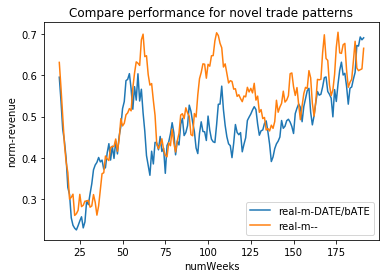

In [190]:
# Compare DATE performances: Between two experiments
plt.figure()
r1 = rival1['DATE-enhanced_bATE--rev'].rolling(window=14).mean()
r2 = rival2['DATE-random--rev'].rolling(window=14).mean()
r3 = rival3['DATE-badge--rev'].rolling(window=14).mean()
r4 = rival4['DATE-bATE--rev'].rolling(window=14).mean()
r5 = rival5['DATE--rev'].rolling(window=14).mean()

plt.plot(r1.index, r1, label=summary.loc[exp1]['data']+'-'+summary.loc[exp1]['subsamplings'])
plt.plot(r2.index, r2, label=summary.loc[exp2]['data']+'-'+summary.loc[exp2]['subsamplings'])
plt.plot(r3.index, r3, label=summary.loc[exp1]['data']+'-'+summary.loc[exp1]['subsamplings'])
plt.plot(r4.index, r4, label=summary.loc[exp2]['data']+'-'+summary.loc[exp2]['subsamplings'])
plt.plot(r5.index, r5, label=summary.loc[exp2]['data']+'-'+summary.loc[exp2]['subsamplings'])
plt.title('Compare performance for novel trade patterns')
plt.legend(loc='lower right')
plt.ylabel(var)
plt.xlabel('numWeeks')
plt.show()
plt.close()